#  Прогнозирование заказов такси

Собраны исторические данные о заказах такси в аэропортах.

Цель:
* Спрогнозировать количество заказов такси на следующий час чтобы привлечь больше водителей в период пиковой нагрузки.

# Подготовка

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.iolib.table import SimpleTable

from collections import deque

import requests
import warnings
warnings.filterwarnings("ignore")

In [2]:
pd.options.display.float_format = '{:0.3f}'.format
pd.options.mode.chained_assignment = None

sns.set_theme(context='paper',
              palette='muted',
              style='whitegrid',
              font_scale=1.1,)

plt.rcParams.update({'lines.linewidth': 1.25,
                     'grid.linewidth': 0.5,
                     'grid.alpha': 0.5,
                     'figure.constrained_layout.use': True,
                     'figure.figsize': (10, 6)})

%config InlineBackend.figure_format = 'retina'

In [3]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0])
df_1D = df.resample('1D').sum()
df_1H = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


## Выводы

* Загружены данные по числу заказов такси, таймфрейм - 10 мин.

# Анализ

Воспользуемся библиотекой statsmodels.tsa для декомпозиции данных.

Сначала посмотрим ряд по дням. Модель выберим multiplicative, так как тренд отличен от линейного.

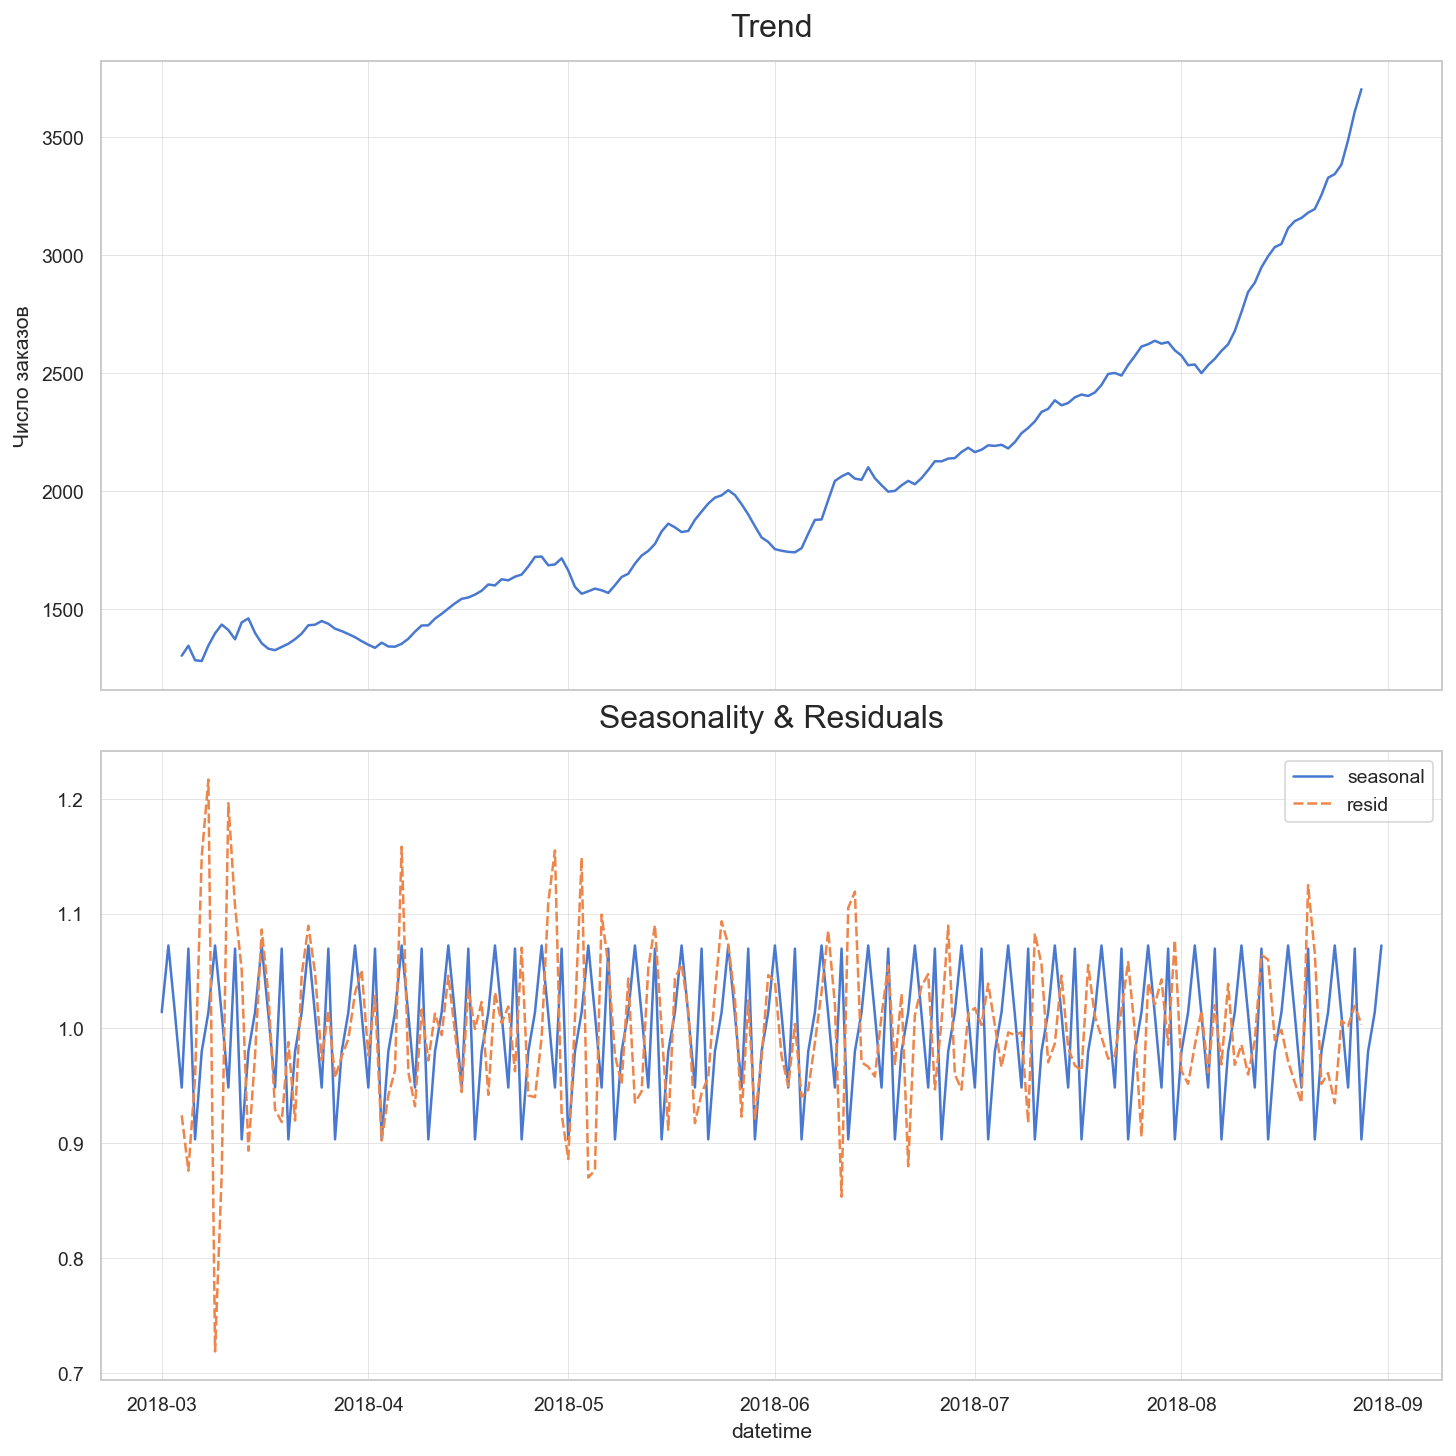

In [4]:
decomposed = seasonal_decompose(df_1D, model='multiplicative')

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(10, 10))
sns.lineplot(data=decomposed.trend, ax=ax1)
sns.lineplot(data=[decomposed.seasonal, decomposed.resid], ax=ax2)
ax1.set_title('Trend', pad=12, fontdict={'size': 16})
ax1.set_ylabel('Число заказов')
ax2.set_title('Seasonality & Residuals', pad=12, fontdict={'size': 16})
plt.show()

Чтобы нагляднее увидеть фактор seasonal посмотрим первые 3 недели.

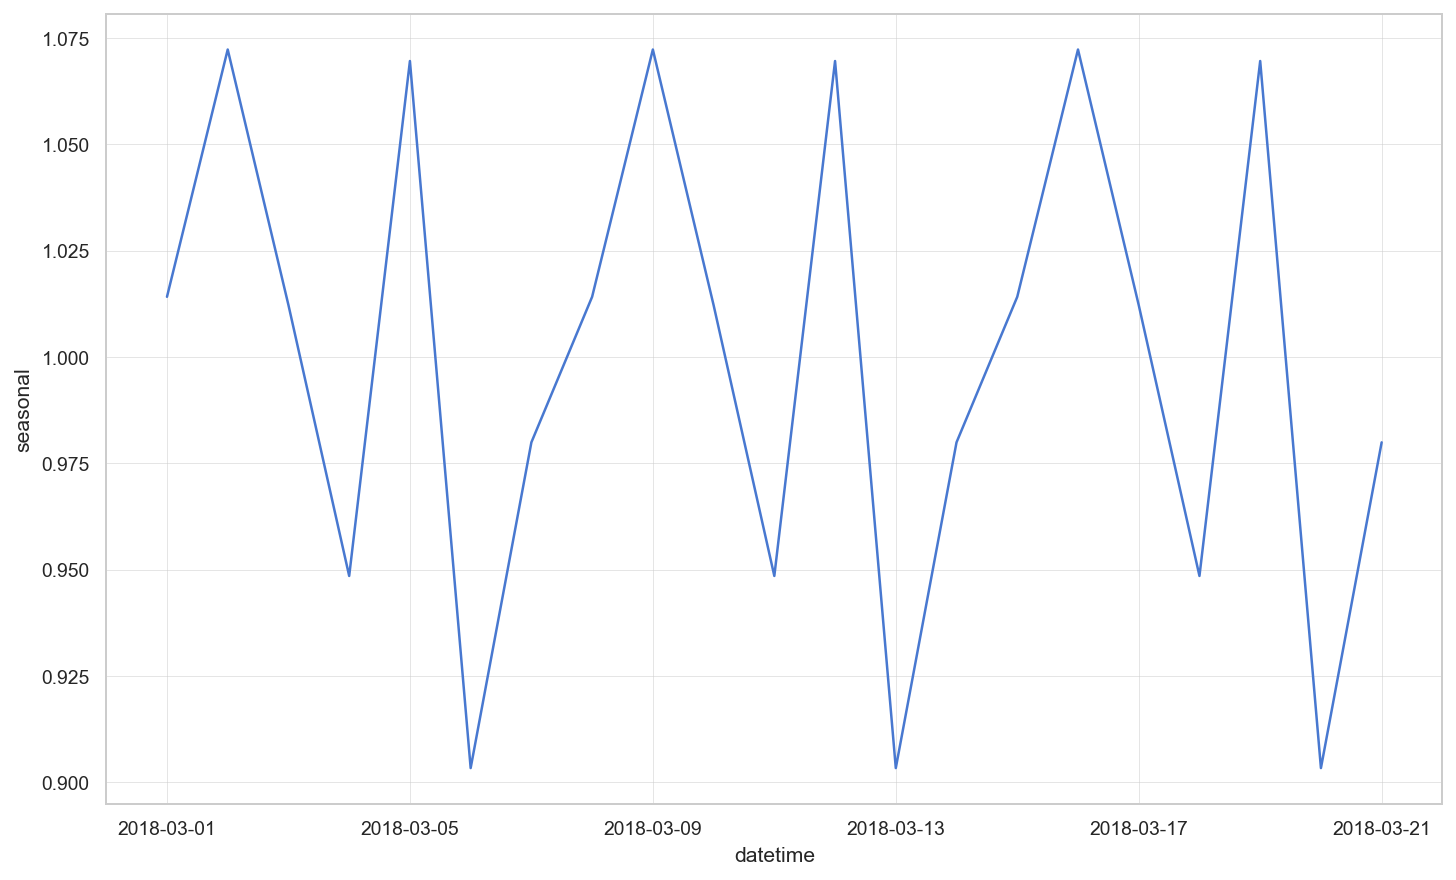

In [5]:
sns.lineplot(data=decomposed.seasonal[:21]);

Теперь посмотрим почасовки 1H. Воспользуемся методом Seasonal and Trend decomposition using Loess (STL).

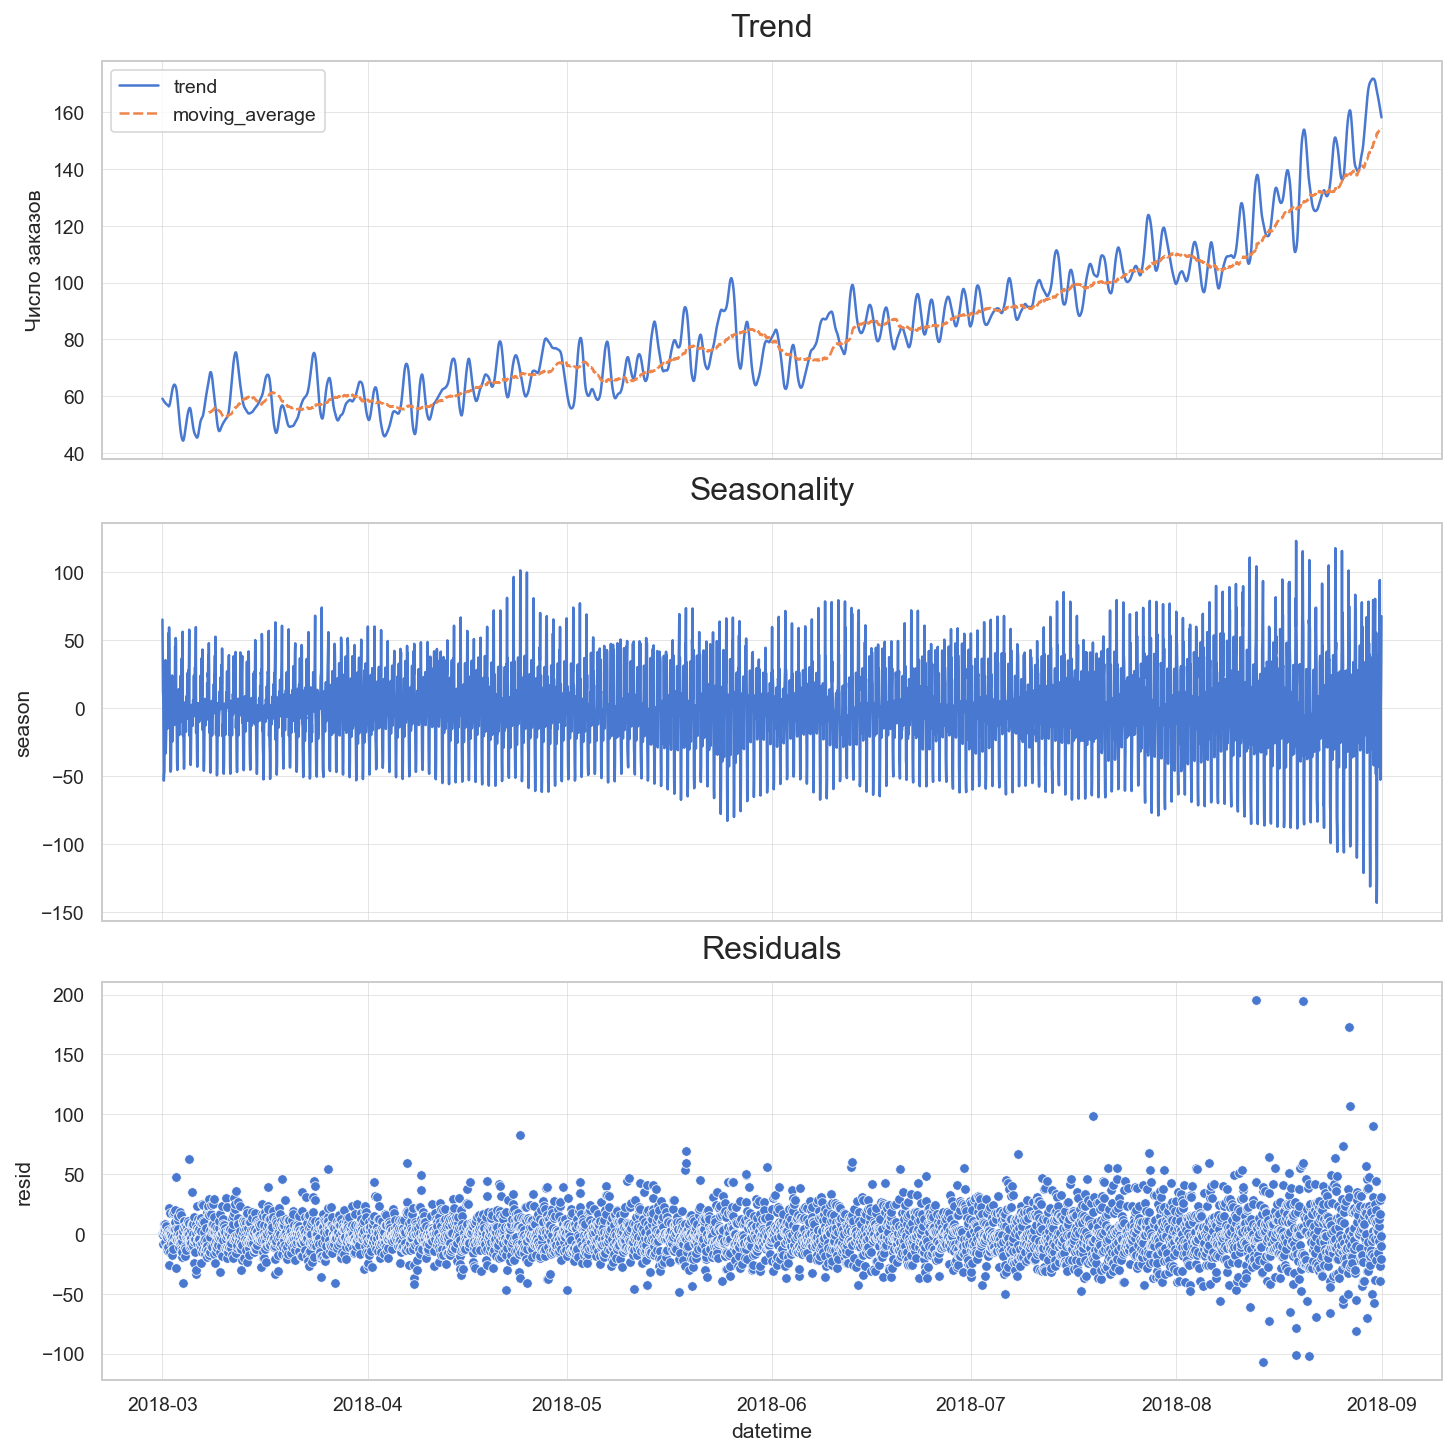

In [6]:
stl = STL(df_1H)
decomposed = stl.fit()

moving_average = df['num_orders'] \
                    .resample('1H').sum() \
                    .shift(1) \
                    .rolling(24*7).mean() \
                    .rename('moving_average')

fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, figsize=(10, 10))
sns.lineplot(data=[decomposed.trend, moving_average],
             ax=ax1)
sns.lineplot(data=decomposed.seasonal, ax=ax2)
sns.scatterplot(data=decomposed.resid, ax=ax3)

ax1.set_title('Trend', pad=12, fontdict={'size': 16})
ax2.set_title('Seasonality', pad=12, fontdict={'size': 16})
ax3.set_title('Residuals', pad=12, fontdict={'size': 16})
ax1.set_ylabel('Число заказов')

plt.show()

Почасовая сезонность - 24 часа.

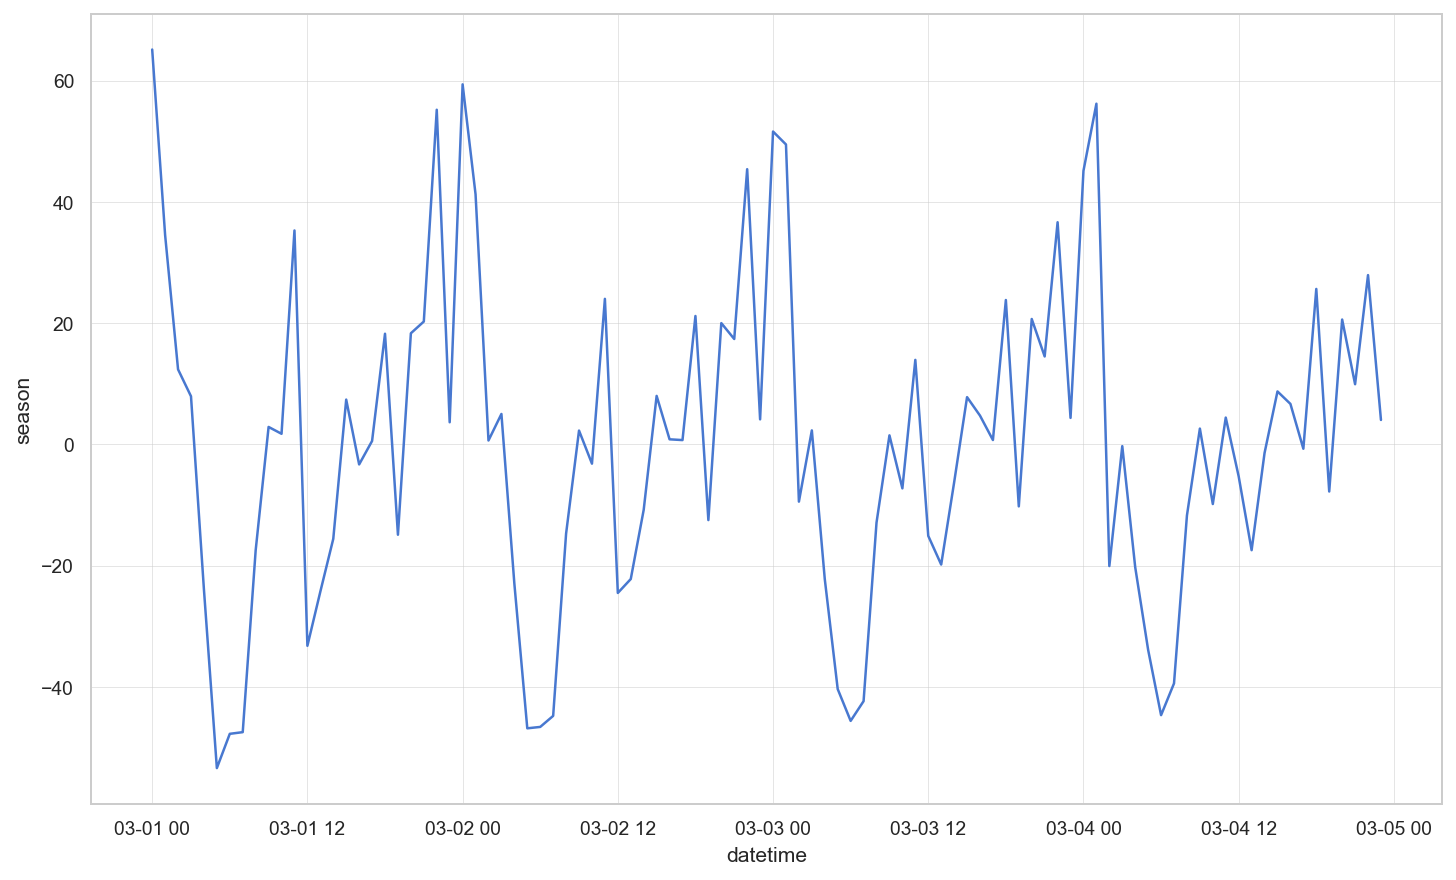

In [7]:
sns.lineplot(data=decomposed.seasonal[:24*4]);

Проведем проверку стационарности используя обобщенный тест Дикки-Фуллера.
* Тест Дикки-Фуллера подтвердил предположения о не стационарности ряда.

In [8]:
def statsmodels_tests(data):
    print('Тест Дикки-Фуллера')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    adfuller_test=adfuller(data, regression='n', maxlag=24)
    display(SimpleTable(np.vstack([adfuller_test]),
                        labels)
    )
    
    if adfuller_test[0] > adfuller_test[4]['5%']:
        print('Есть единичные корни, ряд не стационарен.')
    else:
        print('Единичных корней нет, ряд стационарен.')
    print()   

In [9]:
statsmodels_tests(df_1H)

Тест Дикки-Фуллера


ADF Test Statistic,p-value,#Lags Used,Number of Observations Used
0.19963132517017448,0.7466365579952081,24,4391


Есть единичные корни, ряд не стационарен.



Повторим тесты для разности.

Первые разности ряда стационарны, поэтому он интегрированный ряд первого порядка (Difference Stationary).

* p-value равен 0, а значит нулевая гипотеза о нестационарности ряда может быть отвергнута.

In [10]:
statsmodels_tests(df_1H.diff().dropna())

Тест Дикки-Фуллера


ADF Test Statistic,p-value,#Lags Used,Number of Observations Used
-30.022306096434033,0.0,24,4390


Единичных корней нет, ряд стационарен.



Построим авторкорреляционную (ACF) и частично автокорреляционную (PACF) функции для ряда первых разностей.
Это поможет определить p и q коэффициенты в модели ARIMA.

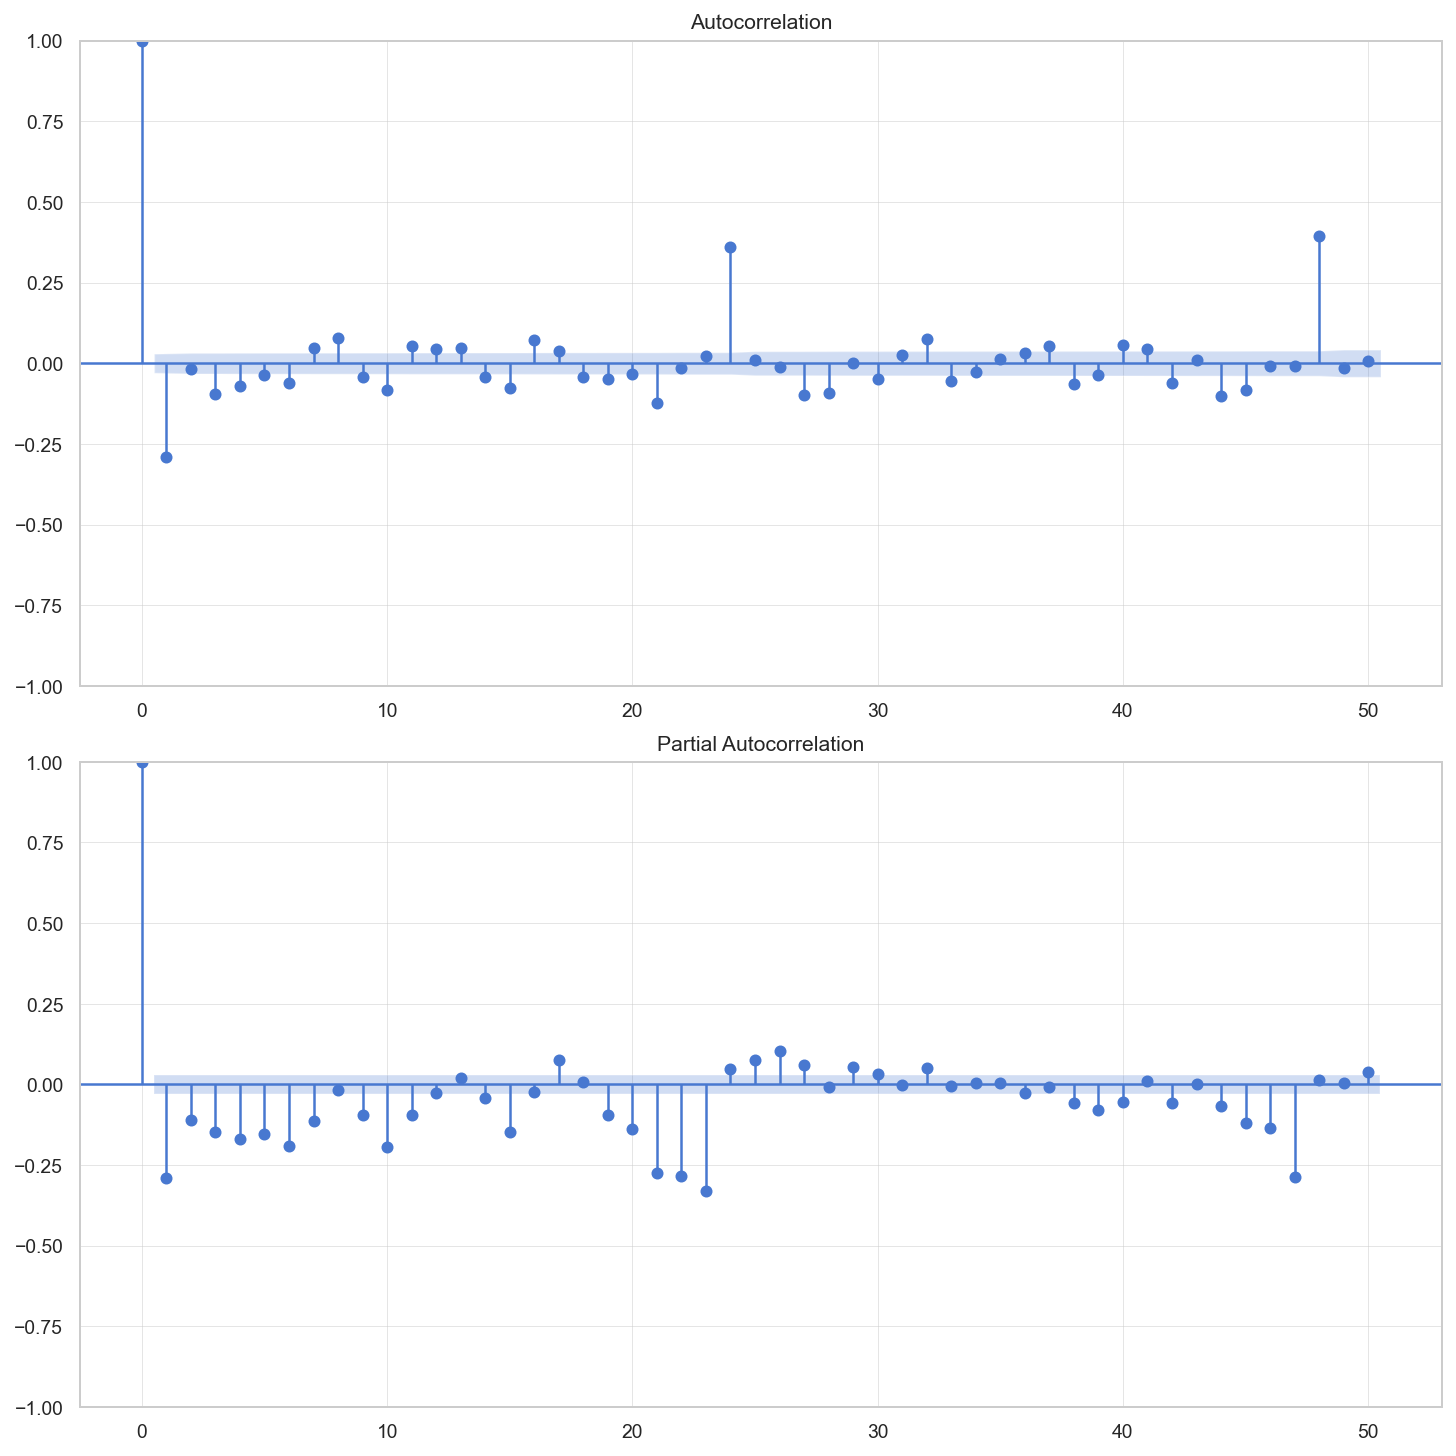

In [11]:
diff = df_1H.diff().dropna()

fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 10))
plot_acf(diff, lags=50, ax=ax1)
plot_pacf(diff, method='ywm', lags=50, ax=ax2)

plt.show()

## Выводы

* Количество заказов такси растет со временем - тренд положительный.
* Ряд не является стационарным за счет ярко выраженного тренда, при этом первые разности ряда стационарны.
* Имеется сезонность внутри недели и одного дня.

# Модели

## Предобработка

Вероятно, что праздники также могут внести вклад в количество заказов. Загрузим их с сайта isdayoff.

In [12]:
def is_holiday(date):
    year = date.year
    month = str(date.month).rjust(2, '0')
    day = str(date.day).rjust(2, '0')
    with requests.get(f'https://isdayoff.ru/api/getdata?year={year}&month={month}&day={day}') as r:
        return r.json()

In [13]:
try:
    holidays = pd1.Series(map(is_holiday, df_1D.index.tolist()), index=df_1D.index)
except:
    # Если сервер не отвечает.
    holidays = [0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
                0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
                1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1,
                1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
                0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0,
                0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
                0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
                0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
                0, 1, 1, 0, 0, 0, 0, 0]
    holidays = pd.Series(holidays, index=df_1D.index)

Добавим лаги и SMA.

In [14]:
def make_features(df, max_lag, ma_window_size):
    df = df.copy()
    
    # Так как мы загружаем данные для дней то часы заполним через ffill.
    df['holiday'] = holidays.resample('1H').ffill()
    df.ffill(inplace=True)
    
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    # По PACF видно, что корреляция с соседним предсказанием
    # и теме же часам с периодичностью в 24 часа максимальна.
    df['lag_1'] = df['num_orders'].shift(1)
    for lag in range(1, max_lag):
        df[f'lag_p{lag}'] = df['num_orders'].shift(lag*24)

    df['moving_average'] = df['num_orders'] \
        .shift(1) \
        .rolling(ma_window_size) \
        .mean()
    
    df.dropna(inplace=True)

    return df

In [15]:
df = make_features(df_1H, 7, 12)
df.head()

,num_orders,holiday,dayofweek,hour,lag_1,lag_p1,lag_p2,lag_p3,lag_p4,lag_p5,lag_p6,moving_average
datetime,,,,,,,,,,,,
2018-03-07 00:00:00,100,0.000,2,0,47.000,42.000,86.000,75.000,163.000,90.000,124.000,54.000
2018-03-07 01:00:00,121,0.000,2,1,100.000,75.000,176.000,60.000,108.000,120.000,85.000,58.917
2018-03-07 02:00:00,24,0.000,2,2,121.000,36.000,32.000,26.000,25.000,75.000,71.000,65.500
2018-03-07 03:00:00,66,0.000,2,3,24.000,49.000,51.000,42.000,64.000,64.000,66.000,64.167
2018-03-07 04:00:00,73,0.000,2,4,66.000,30.000,34.000,27.000,44.000,20.000,43.000,64.417


Выделим тестовую и тренировочную выборку. После чего можно приступать к обучению моделей.

In [16]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

## Линейная модель

При правильном выборе количества лагов даже линейная модель показывает хороший RMSE.

In [17]:
lr = LinearRegression()
lr.fit(features_train, target_train)

mean_squared_error(target_test,
                   lr.predict(features_test),
                   squared=False)

40.23512147173268

## LGBMRegressor

LGBMRegressor считает так же быстро как и LinearRegression, выдавая метрику лучше.

In [18]:
params = {
    'verbose':-1,
    'max_depth': 5,
    'num_iterations': 60,
    'colsample_bytree': 0.85,
    'reg_alpha': 5.5,
    'seed': 38
}

lgb_booster = LGBMRegressor(**params)
lgb_booster.fit(features_train, target_train,)
mean_squared_error(target_test,
                   lgb_booster.predict(features_test),
                   squared=False)

39.68190183135513

## CatBoostRegressor

Сопоставимый результат получился у CatBoostRegressor.

In [19]:
params = {
    'verbose': 0,
    'depth': 5,
    'n_estimators': 1000,
    'subsample': 0.7,
    'random_state': 38
}

cat_booster = CatBoostRegressor(**params)
cat_booster.fit(features_train, target_train)
mean_squared_error(target_test,
                   cat_booster.predict(features_test),
                   squared=False)

39.39964941426059

## STLForecast

STLForecast показывает более слабый результат, но модель выдает прогноз фактически на целый месяц вперед.

Кроме того, её прогнозируемость выше.

In [20]:
# Для STLF воспользуемся всей выборкой.
train, test = train_test_split(df_1H, shuffle=False, test_size=0.1)

In [21]:
stlf = STLForecast(train['num_orders'],
                   model=ARIMA,
                   seasonal=77,
                   model_kwargs={'order': (0, 2, 2)})
stlf = stlf.fit()

forecasts = stlf.get_prediction(start=test.index[0],
                                end=test.index[-1])
mean_squared_error(test['num_orders'],
                   forecasts.predicted_mean,
                   squared=False)

40.369827182860575

Проведем ещё один расчет предсказывая по одному новому значению за раз.

RMSE стал ниже, но время расчета значительно выросло.

In [22]:
test_q = deque(test['num_orders'])
app_train = train['num_orders'].copy()

forecasts = pd.Series()

while len(test_q) > 0:
    stlf = STLForecast(app_train,
                       model=ARIMA,
                       seasonal=77,
                       model_kwargs={'order': (0, 2, 2)}
    )
    
    stlf = stlf.fit()
    forecasts = forecasts.append(
        stlf.forecast(1)
    )
    
    app_train = app_train.append(
        pd.Series(test_q.popleft(), index=[app_train.index[-1] + pd.Timedelta('1H')])
    )
    
mean_squared_error(test['num_orders'],
                   forecasts,
                   squared=False)

38.925266294884274

Визуализируем результат. Модель отлично себя показывает, ошибаясь преимущественно в пиках. 

Можно предположить, что в данные временные периоды роль сыграли и другие факторы, например погода.

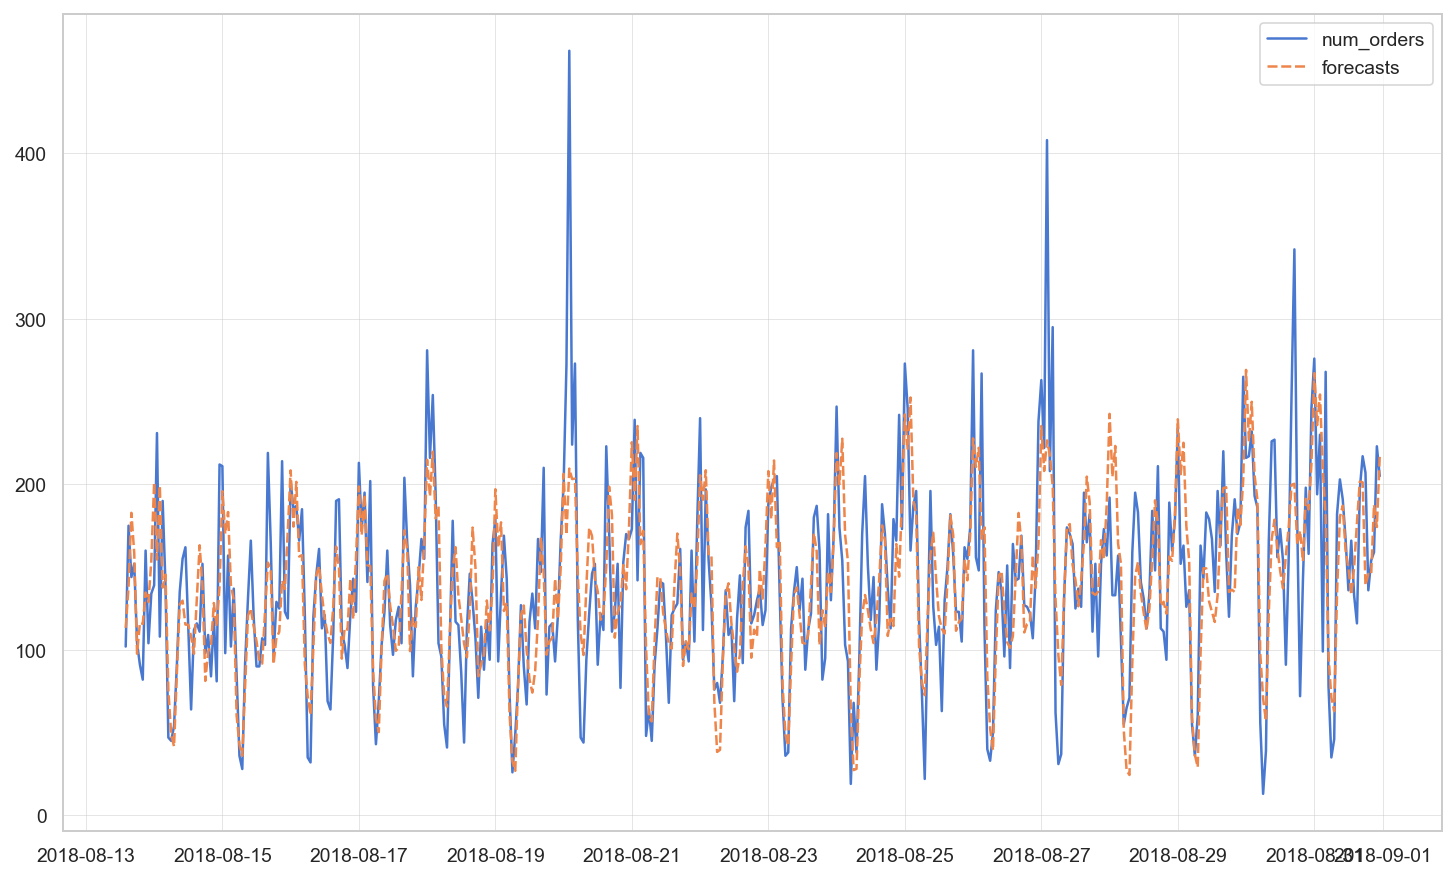

In [23]:
forecasts.name = 'forecasts'
sns.lineplot(data=[test['num_orders'], forecasts]);

# Выводы:

* Спрогнозировано количество заказов такси на следующий час с использование различных моделей.
* Выбрана оптимальная модель, обеспечивающая требуемое значение метрики RMSE на тестовой выборке.
* Лучшая модель для предсказания продолжительных периодов - STLForecast, для краткосрочных прогнозов подойдет CatBoost или LGBMRegressor.